In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Load and preprocess the CIFAR-10 dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# Step 2: Verify the dataset by plotting the first 50 images

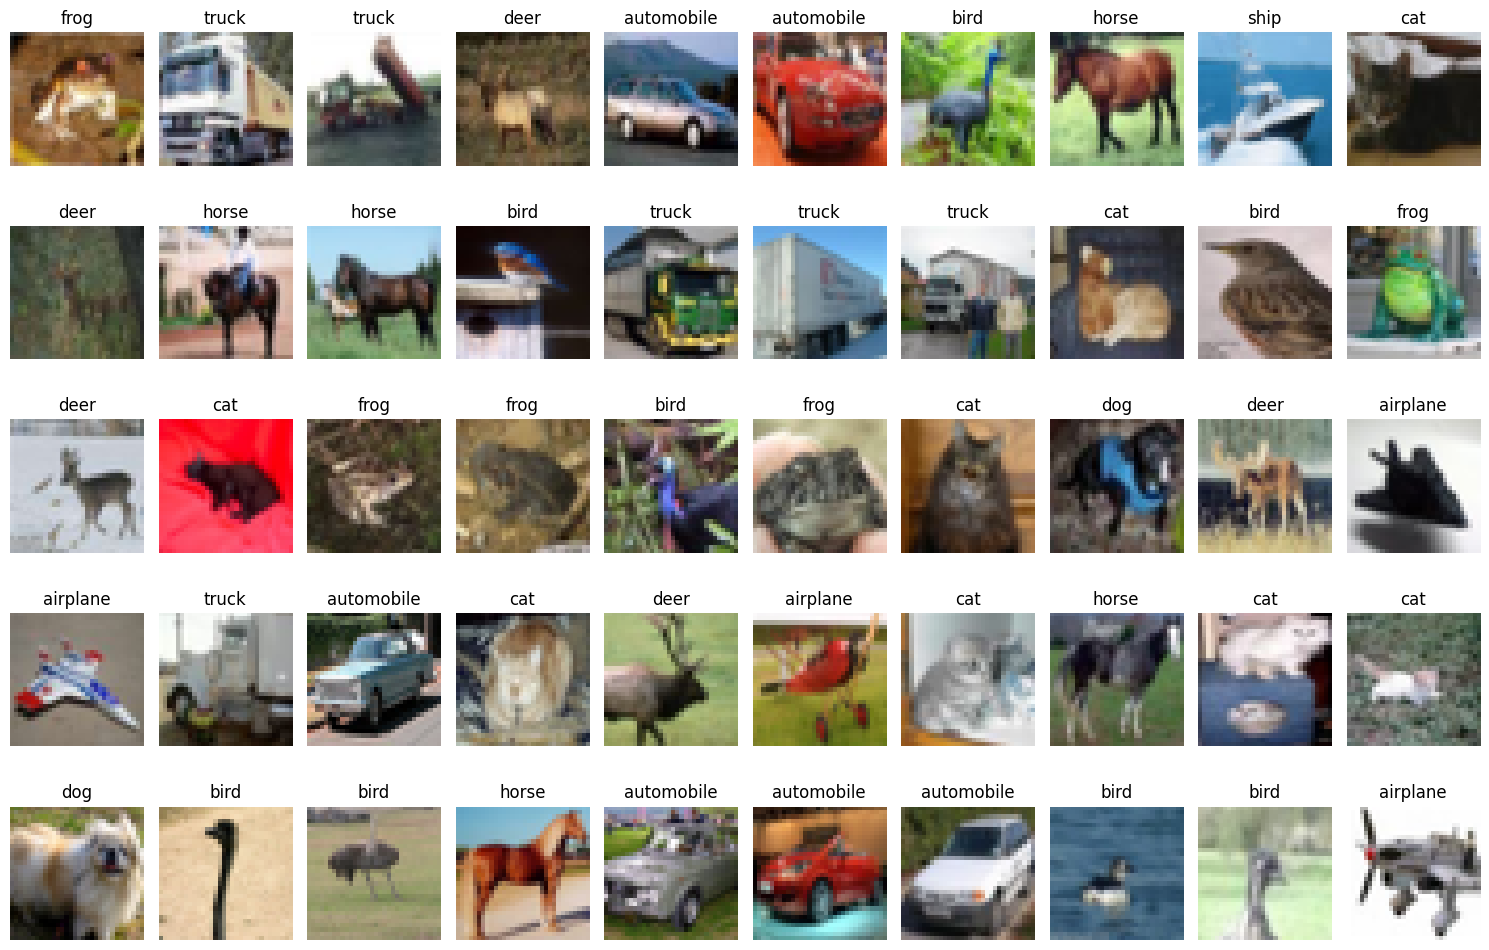

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(15, 10))
rows, cols = 5, 10

for i in range(rows * cols):
    image, label = trainset[i]
    image = image.permute(1, 2, 0)  # Reorder dimensions (C, H, W) to (H, W, C)
    image = (image * 0.5) + 0.5  # Unnormalize the image
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Step 3: Define the neural network architecture


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Step 4: Train the model and evaluate performance


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train_model(model, optimizer, criterion, num_epochs=10):
    model.to(device)
    criterion.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training loop
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(trainloader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        val_losses.append(val_loss / len(testloader))
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies

# Step 5: Perform experiments with different hyperparameters


In [ ]:
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax']
num_epochs = 100

results = []

for lr in learning_rates:
    for optimizer_name in optimizers:
        model = Net().to(device)
        if optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == 'Adagrad':
            optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
        elif optimizer_name == 'Adadelta':
            optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
        elif optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'Adamax':
            optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

        criterion = nn.CrossEntropyLoss().to(device)

        train_losses, val_losses, val_accuracies = train_model(model, optimizer, criterion, num_epochs)

        results.append({
            "Optimizer": optimizer_name,
            "Learning Rate": lr,
            "Validation Accuracy": val_accuracies[-1],
            "Test Accuracy": None
        })

Epoch [1/100], Train Loss: 2.2636, Val Loss: 2.2054, Val Accuracy: 24.59%
Epoch [2/100], Train Loss: 2.1372, Val Loss: 2.0632, Val Accuracy: 28.07%
Epoch [3/100], Train Loss: 2.0239, Val Loss: 1.9711, Val Accuracy: 31.92%
Epoch [4/100], Train Loss: 1.9446, Val Loss: 1.9007, Val Accuracy: 34.90%
Epoch [5/100], Train Loss: 1.8799, Val Loss: 1.8436, Val Accuracy: 36.27%
Epoch [6/100], Train Loss: 1.8307, Val Loss: 1.8029, Val Accuracy: 37.80%
Epoch [7/100], Train Loss: 1.7930, Val Loss: 1.7690, Val Accuracy: 38.84%
Epoch [8/100], Train Loss: 1.7633, Val Loss: 1.7443, Val Accuracy: 39.38%
Epoch [9/100], Train Loss: 1.7373, Val Loss: 1.7193, Val Accuracy: 40.09%
Epoch [10/100], Train Loss: 1.7125, Val Loss: 1.6950, Val Accuracy: 41.21%
Epoch [11/100], Train Loss: 1.6892, Val Loss: 1.6693, Val Accuracy: 41.97%
Epoch [12/100], Train Loss: 1.6639, Val Loss: 1.6425, Val Accuracy: 42.29%
Epoch [13/100], Train Loss: 1.6391, Val Loss: 1.6202, Val Accuracy: 43.56%
Epoch [14/100], Train Loss: 1.6145

# Step 6: Evaluate the best model on the test set and update results


In [ ]:
best_model = Net()
best_optimizer = torch.optim.SGD(best_model.parameters(), lr=0.01)
best_criterion = nn.CrossEntropyLoss()
best_num_epochs = 100

_, _, best_val_accuracies = train_model(best_model, best_optimizer, best_criterion, best_num_epochs)

for i, result in enumerate(results):
    result["Test Accuracy"] = best_val_accuracies[i]

Epoch [1/100], Train Loss: 1.9894, Val Loss: 1.7970, Val Accuracy: 36.59%
Epoch [2/100], Train Loss: 1.6326, Val Loss: 1.5329, Val Accuracy: 45.40%
Epoch [3/100], Train Loss: 1.4601, Val Loss: 1.4602, Val Accuracy: 47.19%
Epoch [4/100], Train Loss: 1.3587, Val Loss: 1.3608, Val Accuracy: 50.58%
Epoch [5/100], Train Loss: 1.2874, Val Loss: 1.2785, Val Accuracy: 54.87%
Epoch [6/100], Train Loss: 1.2331, Val Loss: 1.2890, Val Accuracy: 53.44%
Epoch [7/100], Train Loss: 1.1868, Val Loss: 1.2815, Val Accuracy: 55.75%
Epoch [8/100], Train Loss: 1.1429, Val Loss: 1.1433, Val Accuracy: 60.13%
Epoch [9/100], Train Loss: 1.1024, Val Loss: 1.2368, Val Accuracy: 57.05%
Epoch [10/100], Train Loss: 1.0678, Val Loss: 1.1806, Val Accuracy: 57.83%
Epoch [11/100], Train Loss: 1.0348, Val Loss: 1.0853, Val Accuracy: 62.62%
Epoch [12/100], Train Loss: 1.0088, Val Loss: 1.1048, Val Accuracy: 61.10%
Epoch [13/100], Train Loss: 0.9855, Val Loss: 1.0644, Val Accuracy: 62.28%
Epoch [14/100], Train Loss: 0.9630

# Step 7: Create a table of the results using pandas dataframe


In [ ]:
df = pd.DataFrame(results, columns=["Optimizer", "Learning Rate", "Validation Accuracy", "Test Accuracy"])


# Step 8: Plot the validation accuracies


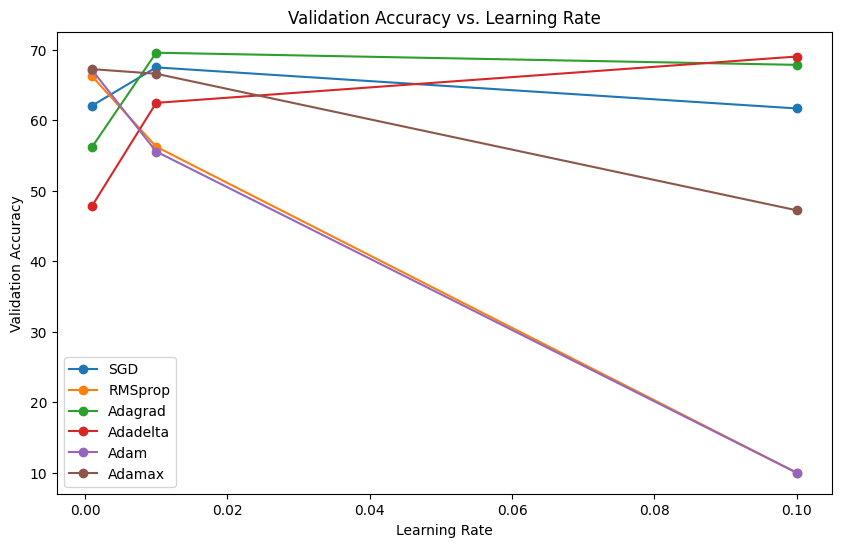

In [ ]:
plt.figure(figsize=(10, 6))
for optimizer_name in optimizers:
    optimizer_results = df[df["Optimizer"] == optimizer_name]
    plt.plot(optimizer_results["Learning Rate"], optimizer_results["Validation Accuracy"], marker='o', label=optimizer_name)

plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Learning Rate")
plt.legend()
plt.show()

# Step 9: Print the results dataframe


In [ ]:
print(df)


   Optimizer  Learning Rate  Validation Accuracy  Test Accuracy
0        SGD          0.001                62.05          36.59
1    RMSprop          0.001                66.19          45.40
2    Adagrad          0.001                56.20          47.19
3   Adadelta          0.001                47.85          50.58
4       Adam          0.001                67.09          54.87
5     Adamax          0.001                67.22          53.44
6        SGD          0.010                67.47          55.75
7    RMSprop          0.010                56.23          60.13
8    Adagrad          0.010                69.55          57.05
9   Adadelta          0.010                62.44          57.83
10      Adam          0.010                55.54          62.62
11    Adamax          0.010                66.57          61.10
12       SGD          0.100                61.65          62.28
13   RMSprop          0.100                10.00          61.81
14   Adagrad          0.100             